In [108]:
from neo4j import GraphDatabase

# Initialize the Neo4j driver
uri = "bolt://localhost:7687"  # Adjust as necessary
username = "neo4j"
password = "password"
driver = GraphDatabase.driver(uri, auth=(username, password))


# Define Cypher scripts - Common part 
# Common part about initialize user and movie
common_init_user = """
MATCH (u:User)-[r:RATED]->(m:Movie)
WITH u, collect(r) AS rcol
WITH u, head(rcol) AS r1
MATCH (u)-[r1]->(m)
WITH u, m, r1.rating AS actual_rating
LIMIT $limit
"""

# Common part about model evaluation
common_eval_model = """
WITH u, m, actual_rating, predict_rating,
    (predict_rating - actual_rating) * (predict_rating - actual_rating) AS square_error

WITH u.id AS user,
    m.title AS movie,
    actual_rating,
    predict_rating,
    square_error
ORDER BY square_error DESC

//Total RSME of test dataset
WITH COUNT(*) AS count, SUM(square_error) AS sse
RETURN count, SQRT(tofloat(sse)/count) AS RMSE
"""

# Content-based Filtering
# Part 1: Find common movies
content_part1 = """
MATCH (u:User)-[r:RATED]->(m:Movie)
WITH u, collect(r) AS rcol
WITH u, head(rcol) AS r1
MATCH (u)-[r1]->(m)
WITH u, m, r1.rating AS actual_rating
LIMIT $limit

// Find other movies that target user has rated
MATCH (u)-[r2:RATED]->(m2:Movie)
WHERE m2.id <> m.id
WITH u, m, actual_rating, m2, r2.rating AS r2_rating

// Find the common genres between target movie m and other movies m2
MATCH (m)-[:HAS_GENRE]->(g:Genre)<-[:HAS_GENRE]-(m2)
WITH u, m, actual_rating, 
    m2, r2_rating, 
    COLLECT(g.name) AS genres, COUNT(*) AS shared_genres
ORDER BY shared_genres DESC
"""

# Part 2: Calculate predict rating
content_part2_avg = """
// Calculate predicted rating
// based on average rating of similar movies with shared_genres
WITH u, m, actual_rating,
    COLLECT(r2_rating)[0..$k] AS r2_ratings

WITH u, m, actual_rating,
    REDUCE(sum = 0, i IN RANGE(0, SIZE(r2_ratings) - 1) | sum + r2_ratings[i]) AS sum,
    SIZE(r2_ratings) AS count_similarity
WITH u, m, actual_rating,
    sum/count_similarity AS predict_rating
WITH u, m, actual_rating,
    ROUND(predict_rating * 2) / 2 AS predict_rating
"""

content_part2_mode = """
// Calculate predict rating
// base on the mode of m2.rating
WITH u, m, actual_rating,
    r2_rating,
    COUNT(r2_rating) AS r2_freq
    ORDER BY r2_freq DESC

WITH u, m, actual_rating,
    COLLECT(r2_rating) AS r2_ratings

WITH u, m, actual_rating,
    (r2_ratings[0..1]) AS predict_ratings

UNWIND(predict_ratings) AS predict_rating
"""

content_part2_median = """
// Calculate predict rating 
// based on the median of similar movies
WITH u, m, actual_rating, 
    COLLECT(r2_rating) AS r2_ratings

WITH u, m, actual_rating,
    CASE 
        WHEN size(r2_ratings) % 2 = 0 
        THEN (r2_ratings[size(r2_ratings) / 2 - 1] + r2_ratings[size(r2_ratings) / 2]) / 2.0
        ELSE r2_ratings[size(r2_ratings) / 2]
    END AS predict_rating
"""


# Collective filtering
collect_part1 = """
// Find other users who rated the same movie
MATCH (u2:User)-[r2:RATED]->(m)
WHERE u2.id <> u.id  // Exclude user 1
WITH u, m, actual_rating, u2, r2.rating AS r2

// Find other common movies that are rated by both user 1 and user 2
MATCH (u)-[r1_common:RATED]->(common_movie:Movie)<-[r2_common:RATED]-(u2)
WHERE common_movie.id <> m.id

// We only return users that have more than 3 common movies with target user u
WITH u, m, actual_rating, u2, r2,
    COUNT(common_movie) AS nb_common_movie, 
    COLLECT(common_movie.id) AS common_movies,
    COLLECT(r1_common.rating) AS u_common_ratings,
    COLLECT(r2_common.rating) AS u2_common_ratings
WHERE nb_common_movie > 3
ORDER BY nb_common_movie DESC
"""

collect_part1_normalized = """
MATCH (u2:User)-[r2:RATED]->(m)
WHERE u2.id <> u.id  // Exclude user 1
WITH u, m, actual_rating, u2, r2.rating AS r2

MATCH (u)-[r:RATED]->(all_m:Movie)
WITH u, m, actual_rating, avg(r.rating) AS u_mean,  
    u2, r2
    
MATCH (u2)-[r:RATED]->(all_m:Movie)
WITH u, m, actual_rating, u_mean,
    u2, r2, avg(r.rating) AS u2_mean

MATCH (u)-[r1_common:RATED]->(common_movie:Movie)<-[r2_common:RATED]-(u2)
WHERE common_movie.id <> m.id

WITH u, m, actual_rating, 
    u2, r2,
    COUNT(common_movie) AS nb_common_movie, 
    // COLLECT(common_movie.id) AS common_movies,
    COLLECT(r1_common.rating - u_mean) AS u_common_ratings_norm,
    COLLECT(r2_common.rating - u2_mean) AS u2_common_ratings_norm
WHERE nb_common_movie > 3
ORDER BY nb_common_movie DESC
"""

collect_part2_non_normalized = """
// Calculate cosine similarity
WITH u, m, actual_rating, 
    u2, r2, common_movies, nb_common_movie,
    REDUCE(dot_product = 0, i IN RANGE(0, SIZE(u_common_ratings) - 1) | dot_product + (u_common_ratings[i] * u2_common_ratings[i])) AS dot_product,
    SQRT(REDUCE(xDot = 0.0, a IN u_common_ratings | xDot + a^2)) AS x_length,
    SQRT(REDUCE(yDot = 0.0, b IN u2_common_ratings | yDot + b^2)) AS y_length

WITH u, m, actual_rating, 
    u2, r2, common_movies, nb_common_movie, x_length, y_length, dot_product,
    CASE WHEN x_length * y_length = 0 THEN 0 ELSE dot_product / (x_length * y_length) END AS similarity

MERGE (u)-[s:SIMILARITY]-(u2)
SET   s.similarity = similarity
"""

collect_part2_normalized = """
// Calculate cosine similarity
WITH u, m, actual_rating, 
    u2, r2,
    nb_common_movie,
    REDUCE(dot_product = 0, i IN RANGE(0, SIZE(u_common_ratings_norm) - 1) | dot_product + (u_common_ratings_norm[i] * u2_common_ratings_norm[i])) AS dot_product,
    SQRT(REDUCE(xDot = 0.0, a IN u_common_ratings_norm | xDot + a^2)) AS x_length,
    SQRT(REDUCE(yDot = 0.0, b IN u2_common_ratings_norm | yDot + b^2)) AS y_length

WITH u, m, actual_rating, 
    u2, r2, x_length, y_length, dot_product,
    nb_common_movie,
    CASE WHEN x_length * y_length = 0 THEN 0 ELSE dot_product / (x_length * y_length) END AS similarity

MERGE (u)-[s:SIMILARITY]-(u2)
SET   s.similarity = similarity
"""

collect_part3 = """
// Find k-nearest neighbors of target user
// We set k = 5
// We only take users that have positive similarity with target user u
WITH u, m, actual_rating,
    u2, r2, similarity, nb_common_movie
WHERE similarity > 0
ORDER BY u.id, similarity DESC, nb_common_movie DESC

WITH u, m, actual_rating,
    COLLECT(r2)[0..$k] AS r2_rating,
    COLLECT(similarity)[0..$k] AS similarity
"""

collect_part4_avg = """
// Calculate the predict rating
// based on average of k-NN users
WITH u, m, actual_rating,
    REDUCE(sum = 0, i IN RANGE(0, SIZE(similarity) - 1) | sum + (similarity[i] * r2_rating[i])) AS weighted_sum,
    REDUCE(sum = 0, i IN RANGE(0, SIZE(similarity) - 1) | sum + similarity[i]) AS total_weight
    // SIZE(similarity) AS count_similarity
    
WITH u, m, actual_rating,
    weighted_sum / total_weight AS predict_rating

WITH u, m, actual_rating,
    ROUND(predict_rating * 2) / 2 AS predict_rating
"""

collect_part4_bin = """
WITH u, m, actual_rating, r2_rating

UNWIND(r2_rating) AS r2_ratings

WITH u, m, actual_rating, r2_ratings,
     CASE 
        WHEN 0 < r2_ratings <= 1 THEN 'Bin 1'
        WHEN 1 < r2_ratings <= 2 THEN 'Bin 2'
        WHEN 2 < r2_ratings <= 3 THEN 'Bin 3'
        WHEN 3 < r2_ratings <= 4 THEN 'Bin 4'
        WHEN 4 < r2_ratings <= 5 THEN 'Bin 5'
    END AS bin

WITH u, m, actual_rating, 
    COLLECT(r2_ratings) AS r2_rating, 
    bin, COUNT(bin) AS nb_r2_rating 
ORDER BY u, m, nb_r2_rating DESC

WITH u, m, actual_rating,
    COLLECT(r2_rating) AS r2_rating, 
    COLLECT(nb_r2_rating) AS nb_r2_rating

WITH u, m, actual_rating,
    r2_rating[0..1] AS r2_rating

UNWIND(r2_rating) AS r2_ratings

WITH u, m, actual_rating, 
    REDUCE(sum = 0, i IN RANGE(0, SIZE(r2_ratings) - 1) | sum + r2_ratings[i]) AS sum_bin,
    SIZE(r2_ratings) AS size

WITH u, m, actual_rating,
    ROUND(sum_bin/size * 2) / 2 AS predict_rating
"""


In [109]:
# Total queries

# Content based filtering
content_avg = common_init_user + content_part1 + content_part2_avg + common_eval_model
content_mode = common_init_user + content_part1 + content_part2_mode + common_eval_model
content_median = (
    common_init_user + content_part1 + content_part2_median + common_eval_model
)


# Collective filtering
collect_normalized = (
    common_init_user
    + collect_part1_normalized
    + collect_part2_normalized
    + collect_part3
    + collect_part4_avg
    + common_eval_model
)

collect_non_normalized = (
    common_init_user
    + collect_part1
    + collect_part2_non_normalized
    + collect_part3
    + collect_part4_avg
    + common_eval_model
)


collect_bin = (
    common_init_user
    + collect_part1
    + collect_part2_non_normalized
    + collect_part3
    + collect_part4_bin
    + common_eval_model
)

# List of cyphers
ls_cyphers = {
    "content-filter (avg)": content_avg,
    "content-filter (median)": content_median,
    "content-filter (mode)": content_mode,
    "collective-filter (normalized)": collect_normalized,
    "collective-filter (non-normalized)": collect_non_normalized,
    "collective-filter (bin)": collect_bin,
}


# List of parameters
k = [1, 5, 10]
limit = [10, 50, 100, 150]
ls_params = [{"k": k_value, "limit": limit_value} for k_value in k for limit_value in limit]

In [110]:
import time 

# Function to run a Cypher query
def run_query(query,params):
    with driver.session() as session:
        result = session.run(query, params)
        return [record.data() for record in result]

total_simu = []
# Run simualation
for name, cypher in ls_cyphers.items(): 
    simu = {}
    simu["method"] = name 

    for params in ls_params:
        start_time = time.time()
        results = run_query(cypher, params)
        run_time = time.time() - start_time

        # store result
        simu["k"] = params["k"]
        simu["limit"] = params["limit"]
        simu["RMSE"] = results[0]["RMSE"]
        simu["run time"] = run_time
    
        total_simu.append(simu.copy())

# Close the driver connection
driver.close()

In [162]:
# Process the result and save data table

import pandas as pd

result_df = pd.DataFrame(total_simu)

# Split method column
result_df[['method', 'variant']] = result_df['method'].str.extract(r'([^\(]+)\s?\(([^)]+)\)')
result_df = result_df[["method", "variant", "k", "limit", "RMSE", "run time"]]

result_df = result_df.sort_values(by=["method", "k", "limit", "variant"], ascending=[False, True, True, True]).reset_index(drop=True)
result_df.to_pickle("tables/result.pkl")

# Save csv file
result_df.to_csv("tables/result.csv", index=False)
result_df_short = result_df[result_df["limit"] == 150]
result_df_short.to_csv("tables/result_short.csv", index=False, float_format='%.3f')
result_df

,method,variant,k,limit,RMSE,run time
0,content-filter,avg,1,10,1.204159,0.018519
1,content-filter,median,1,10,0.938749,0.009260
2,content-filter,mode,1,10,0.741620,0.010595
3,content-filter,avg,1,50,1.266886,0.075769
4,content-filter,median,1,50,1.134681,0.075475
...,...,...,...,...,...,...
67,collective-filter,non-normalized,10,100,1.035969,10.367186
68,collective-filter,normalized,10,100,1.015191,12.722432
69,collective-filter,bin,10,150,1.114250,16.804330
70,collective-filter,non-normalized,10,150,1.025848,16.500262


# Analysis from saved file

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

result_df = pd.read_pickle("tables/result.pkl")

In [ ]:
# trim space
result_df["method"] = result_df["method"].str.strip()

# change column name
result_df.rename(columns={"limit": "nb_user"}, inplace=True)

result_df

,method,variant,k,nb_user,RMSE,run time
0,content-filter,avg,1,10,1.204159,0.018519
1,content-filter,median,1,10,0.938749,0.009260
2,content-filter,mode,1,10,0.741620,0.010595
3,content-filter,avg,1,50,1.266886,0.075769
4,content-filter,median,1,50,1.134681,0.075475
...,...,...,...,...,...,...
67,collective-filter,non-normalized,10,100,1.035969,10.367186
68,collective-filter,normalized,10,100,1.015191,12.722432
69,collective-filter,bin,10,150,1.114250,16.804330
70,collective-filter,non-normalized,10,150,1.025848,16.500262


In [9]:
result_df[result_df["nb_user"] == 10]

,method,variant,k,nb_user,RMSE,run time
0,content-filter,avg,1,10,1.204159,0.018519
1,content-filter,median,1,10,0.938749,0.009260
2,content-filter,mode,1,10,0.741620,0.010595
12,content-filter,avg,5,10,0.774597,0.010207
13,content-filter,median,5,10,0.938749,0.010385
14,content-filter,mode,5,10,0.741620,0.010929
24,content-filter,avg,10,10,0.570088,0.009357
25,content-filter,median,10,10,0.938749,0.009380
26,content-filter,mode,10,10,0.741620,0.009981
36,collective-filter,bin,1,10,0.935414,0.499584


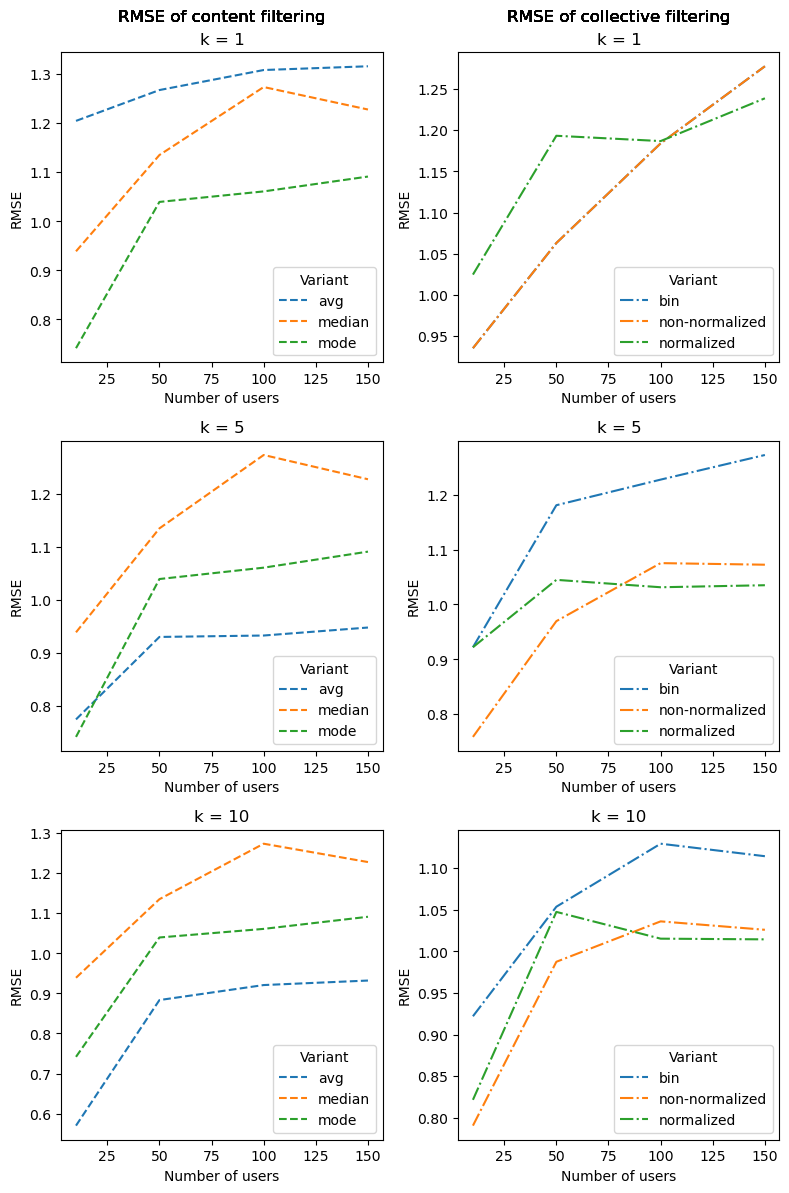

In [209]:
import matplotlib.pyplot as plt

# Plot result
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

# Filter and plot for 'content-filter'
result_df_content = result_df[result_df["method"] == "content-filter"]
for variant in result_df_content["variant"].unique():
    for idx, k_value in enumerate(result_df["k"].unique()):
        data_ = result_df_content[(result_df_content["variant"] == variant) & (result_df_content["k"] == k_value)]
        ax = axs[idx, 0]
        ax.plot(data_["limit"], data_["RMSE"], label=variant, linestyle="--")
        ax.set_title(f"k = {k_value}")
        ax.set_xlabel('Number of users')
        ax.set_ylabel('RMSE')
        ax.legend(title='Variant', loc="lower right")
        axs[0, 0].annotate("RMSE of content filtering", xy=(0.5, 1.1), xycoords="axes fraction", ha="center", fontsize=12)


# Filter and plot for 'content-filter'
result_df_collect = result_df[result_df["method"] == "collective-filter"]
for variant in result_df_collect["variant"].unique():
    for idx, k_value in enumerate(result_df["k"].unique()):
        data_ = result_df_collect[(result_df_collect["variant"] == variant) & (result_df_collect["k"] == k_value)]
        ax = axs[idx, 1]
        ax.plot(data_["limit"], data_["RMSE"], label=variant, linestyle="-.")
        ax.set_title(f"k = {k_value}")
        ax.set_xlabel('Number of users')
        ax.set_ylabel('RMSE')
        ax.legend(title='Variant', loc="lower right")
        axs[0, 1].annotate("RMSE of collective filtering", xy=(0.5, 1.1), xycoords="axes fraction", ha="center", fontsize=12)


# Save the plot
# plt.savefig("figures/rmse-plot.png", dpi=300)


# Show plots
plt.tight_layout()
plt.show()